In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
#pip install -U statsmodels
import statsmodels.api as sm 

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#  Preprocesamiento de Datos

El analisis exploratorio que se presenta a continuacion tiene como fin determinar que feathers influyen en mayor medida a la hora de determinar el precio de un inmueble en Capital Federal y Gran Buenos Aires, asi como tambien encontrar datos curiosos en el data set.

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y reorganizo en un solo dataset de la siguiente manera : [GitHub | properati_argentina](https://github.com/BraianVicente/properati_argentina/blob/master/src/TP1%20-%20Properati%20-%20Parseo%20de%20datos%20por%20fecha.ipynb)

In [4]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

Transformando el formato del feature created_on para manejarlo como fecha

In [5]:
sell_properati['created_on'] = sell_properati['created_on'].apply(lambda x : pd.to_datetime(x))

In [6]:
sell_properati['year'] = sell_properati['created_on'].apply(lambda x : x.year)

In [7]:
def parse_year_month(date):
    if len(str(date.month)) == 1 :
        return str(date.year) + '-0' + str(date.month)
    return str(date.year) + '-' + str(date.month) 

In [8]:
sell_properati['year_month'] = sell_properati.created_on.apply(parse_year_month)

Completamos la columna 'state_name'

In [9]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

Filtramos unicamente los que nos interesan que corresponde a capital federal y alrededores

In [10]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [11]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [12]:
sell_properati.drop(inplace=True,\
    labels=['country_name','description','extra','id', u'image_thumbnail','operation'\
            ,'place_with_parent_names_l1','place_with_parent_names_l2', 'properati_url','surface_in_m2','title',\
           ],axis=1)

Podemos seguir trabajando con los datos que no cuentan con la informacion de Zona utilizando la ubicacion para identificarlos segun el barrio al que pertenecen pero en esta ocacion decidimos dejarlos de lado pues no son una cantidad significativa de datos

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [13]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [14]:
sell_properati = sell_properati[sell_properati['zone'] != '']

In [15]:
#Calcula el precio la incognita (incognita = divisor/dividendo) para todo divisor mayor a cero y todo dividendo mayor a cero.

def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

# Continuaremos trabajando con el set de datos completo para disponer de toda la informacion.

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [16]:
sell_properati_filter = sell_properati

In [17]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [18]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [19]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [20]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [21]:
sell_properati_filter = sell_properati_filter[~((sell_properati_filter['surface_total_in_m2'] == 0 ) | \
                     (sell_properati_filter['price'] == 0 ))]

In [22]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    7402.093163
price_usd_per_m2       2268.710530
price_per_m2           3892.322905
dtype: float64

In [23]:
sell_properati_filter[(pd.notnull(sell_properati_filter['surface_total_in_m2']))]\
            [['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].shape

(278094, 5)

Filtraremos los datos que tengan una superficie total en metros cuadrados entre 0 y 1000

In [24]:
filter_properati = sell_properati_filter[(sell_properati_filter['price_aprox_usd'] < 600000) &\
                                         (sell_properati_filter['price_usd_per_m2'] < 5000) & \
                                         (sell_properati_filter['surface_total_in_m2'] < 1000)]

In [25]:
float(filter_properati.shape[0]) / float(sell_properati.shape[0]) * 100

62.02927539329903

In [26]:
filter_properati.columns

Index([u'created_on', u'currency', u'expenses', u'floor', u'geonames_id',
       u'lat', u'lat-lon', u'lon', u'place_name', u'place_with_parent_names',
       u'price', u'price_aprox_local_currency', u'price_aprox_usd',
       u'price_per_m2', u'price_usd_per_m2', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_total_in_m2',
       u'year', u'year_month', u'zone'],
      dtype='object')

In [27]:
data = filter_properati[['floor','expenses','price_aprox_usd','rooms','surface_total_in_m2']].copy()

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243749 entries, 2 to 597227
Data columns (total 5 columns):
floor                  47217 non-null float64
expenses               19623 non-null object
price_aprox_usd        243749 non-null float64
rooms                  160435 non-null float64
surface_total_in_m2    243749 non-null float64
dtypes: float64(4), object(1)
memory usage: 11.2+ MB


In [29]:
def devolverInt(x):
    return float(re.search(r'\d+', x).group())

In [30]:
import re
string1 = "$ 1500.- aprox results should get"
int(re.search(r'\d+', string1).group())


1500

In [31]:
devolverInt(string1)

1500.0

In [32]:
data['expenses'] = data.expenses.apply(lambda x : devolverInt(x) if pd.notnull(x) else 0 )

In [33]:
data['floor'] = data.floor.apply(lambda x : float(x) if pd.notnull(x) else 0 )

data['lat'] = data.lat.apply(lambda x : float(x) if pd.notnull(x) else 0 )

data['lon'] = data.lon.apply(lambda x :float(x) if pd.notnull(x) else 0 )

In [34]:
data['price_aprox_usd'] = data.price_aprox_usd.apply(lambda x : float(x) if pd.notnull(x) else 0 )

data['price_usd_per_m2'] = data.price_usd_per_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [35]:
data['rooms'] = data.rooms.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [36]:
data['surface_total_in_m2'] = data.surface_total_in_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [37]:
data.tail()

,floor,expenses,price_aprox_usd,rooms,surface_total_in_m2
597200,0.0,0.0,130000.0,1.0,49.0
597213,0.0,0.0,160000.0,4.0,203.0
597221,0.0,0.0,65000.0,2.0,120.0
597225,0.0,8600.0,550000.0,3.0,324.0
597227,1.0,0.0,450000.0,3.0,268.0


In [69]:
train = data.sample(int(float(data.shape[0]) * 0.8)).copy()

In [70]:
test = data.sample(int(float(data.shape[0]) * 0.1)).copy()

# Machine Learning


In [71]:
train_target = train[['price_aprox_usd']].copy()

In [72]:
train.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [73]:
test_target = test[['price_aprox_usd']].copy()

In [74]:
test.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [75]:
msqDF = pd.DataFrame(columns={'k-Neighbors','p_minkowski','mean_squear_error'})

In [76]:
from sklearn import neural_network

In [93]:
mlp = neural_network.MLPRegressor(activation='logistic')

In [94]:
mlp.fit(train,train_target)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [95]:
test_prediction = mlp.predict(test)

In [96]:
msq_mlp = mean_squared_error(test_prediction, test_target)

In [97]:
msq_mlp

37590153924.057579

In [98]:
predictionDF = pd.DataFrame(test_prediction,columns={"prediction"})


In [99]:

predictionDF.loc[:,'spectate'] = test_target.values


In [100]:

def predictError(predict,spectate): 
    if (spectate > predict) : 
        return ((spectate-predict)/spectate)*100 
    else : return ((predict-spectate)/predict )*100


In [101]:
predictionDF['errorValue'] = predictionDF.apply(axis=1,func=lambda x : predictError(x[0],x[1]))


In [102]:
predictionDF.sample(5)


,prediction,spectate,errorValue
10327,19657.31252,275000.0,92.851886
3578,19657.31252,110000.0,82.129716
5907,19657.31252,128000.0,84.642725
3536,19657.31252,104160.0,81.127772
16193,19657.31252,75000.0,73.790250


In [103]:
print 'El error promedio que comete Random Forest Regresion al predecir es de', float(predictionDF['errorValue'].mean()),'%'


El error promedio que comete Random Forest Regresion al predecir es de 83.900365897 %


In [104]:
print "El algoritmo Multi Label Perceptron predice un ",\
        (float(predictionDF[predictionDF['errorValue'] < 10].shape[0]) / float(predictionDF.shape[0] )* 100) ,\
        "% de los valores, con un error menor al 15%"

El algoritmo Multi Label Perceptron predice un  0.0615409862969 % de los valores, con un error menor al 15%


In [105]:
predictionDF.describe()

,prediction,spectate,errorValue
count,24374.000000,24374.000000,24374.000000
mean,19657.312520,176002.949146,83.900366
std,0.000003,114659.213357,10.010219
min,19657.312150,5000.000000,1.713437
25%,19657.312520,90500.000000,78.279213
50%,19657.312520,140000.000000,85.959062
75%,19657.312520,230000.000000,91.453342
max,19657.312520,598500.000000,96.715570


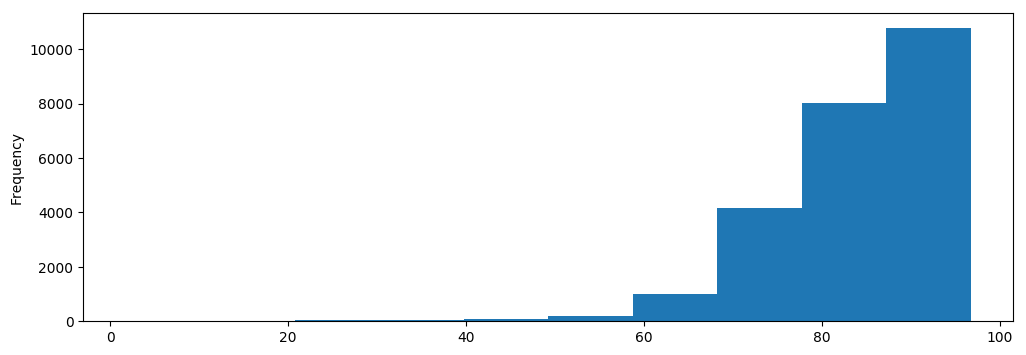

In [106]:
predictionDF.errorValue.plot.hist()